### Feature Importance

이번 절에서는 머신러닝의 특성 중요도 방법 중 두 가지가 계산 기법을 사용해 최소의 가정으로 $p$-value의 결함을 어떻게 다루는지 연구한다. 머신러닝 해석 방법의 다른 예로는 accumulated local effects(Apley, 2016)와 Shapley value(2014)가 있다.

In [1]:
import pandas as pd
import numpy as np
from FinancialMachineLearning.generator.classification_data import get_test_data

In [2]:
trnsX, cont = get_test_data(
    n_features = 40, 
    n_informative = 5, 
    n_redundant = 30, 
    n_samples = 10000,
    sigma_std = 0.1,
    random_state = 0
)

#### 1. Mean Decrease Impurity

F개의 특성과 관찰당 하나의 레이블로 구성된 크기 N개의 학습 샘플을 갖고 있다고 가정하자. Tree Model을 기반으로 하는 분류/회귀 알고리즘은 각 노트 $t$에서 label을 2개의 샘플로 분할한다. 주어진 feature $X_f$에 대해 임의의 threshold $\tau$이하의 $X_f$와 연관된 노드 $t$의 label은 왼쪽 샘플에 배치하고, 나머지는 오른쪽 샘플에 배치한다. 이를 분기라고 하며, Tree를 기반으로 하는 Random Forest, XG Boost, Cat Boost등 대부분의 Ensemble Model이 이러한 분기의 과정을 거친다

각 샘플에 대해 label값의 분포의 Entropy, Gini impurity 혹은 이외의 기준을 따라서 불순도를 평가할 수 있다. 직관적으로, 샘플은 한 종류의 label만을 담았을 때 가장 순수하며, label이 균등 분포를 따를 때 가장 impurity가 높다고 할 수 있다. 분할에 의해 얻을 수 있는 정보 이득은 아래와 같이 불순도의 감소로 측정된다

$$\Delta g(t, f) = i(t) - \frac{N_t^{(0)}}{N_t}i(t^{(0)}) - \frac{N_t^{(1)}}{N_t}i(t^{(1)})$$

여기서 $i(t)$는 노드 $t$에서의 label의 불순도이고, $i(t^{(0)})$는 왼쪽으로 분기된 샘플의 불순도, $i(t^{(1)})$은 오른쪽으로 분기된 샘플의 불순도이다

각 노드 $t$에서 분류모형은 $\{X_f\}_{1, \dots, F}$의 다양한 feature에 대해 $\Delta g(t, f)$를 평가하고, 이들 각각에 대해 $\Delta g(t, f)$를 최대화하는 최적 임계값 $t$를 결정하고, 최대 $\Delta g(t, f)$와 연관된 특성을 선택한다. 분류 알고리즘은 더 이상의 Information Gain(정보 이득)이 발생하지 않거나 최대 허용 한도 미만으로 불순도를 달성하는 등의 조기 종료 조건이 충족될 때까지 샘플을 분기한다

Feature Importance는 특성이 선택된 모든 노드에서 Weighted Information Gain(가중 정보 이득)으로 계산할 수 있다. Breiman(2001)이 도입한 이 트리 기반의 Feature importance 개념은 Mean Decrease Impurity로 알려져 있다. 구성에 의해 각 특성과 관련된 MDI 값은 0과 1 사이에 존재하며, 모두 합치면 최대 1이 된다. 모두 무정보적(즉, 동등한 정보를 가진)인 $F$ 특성이 있는 경우 각 MDI 값은 $\frac{1}{F}$가 될 것으로 예상된다. Random Forest와 같이 트리의 앙상블을 결합하는 알고리즘에 대해서는 모든 트리에서 각 특성에 대한 MDI 값의 평균과 분산을 추가로 추정할 수 있다. 이러한 평균 및 분산 추정치는 Central Limit Theorem과 함께 사용자 정의의 귀무가설에 대한 특성의 유의성을 검정하는 데 유용하다. 아래의 코드는 Ensemble MDI process를 구현한다.

In [3]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [7]:
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold, cross_val_score
cv_gen = PurgedKFold(
    n_splits = 5, 
    samples_info_sets = cont['t1']
)

In [8]:
oos_score = cross_val_score(
    forest, # base classifier
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

In [9]:
from FinancialMachineLearning.feature_importance.importance import *
mdi = mean_decrease_impurity(fit, trnsX.columns)

In [10]:
mdi.head()

,mean,std
I_0,0.025054,0.000896
I_1,0.038906,0.001406
I_2,0.037953,0.001161
I_3,0.013420,0.000152
I_4,0.030561,0.000731


아래의 그림은 p-value에서 논의된 것과 동일한 무작위 분류 문제에 MDI를 적용한 결과를 나타낸다. 가로 막대는 Random Forest에 있는 1,000여개의 트리에서 MDI 평균을 나타내며, 선은 그 평균 주위의 표준 편차를 나타낸다. Forest에 Tree를 더할수록 평균 주위의 표준편차가 작아진다. MDI는 잡음 특성이 아닌 모든 특성이 잡음 특성보다 더 높은 순위를 차지한다는 점에서 좋은 성과를 내고 있다. 그럼에도 소수의 잡음이 없는 특성들이 비슷한 특성들보다 훨씬 더 중요한 것으로 보인다. 이것은 중복 특성이 있는 곳에서 발견될 것으로 예성되는 일종의 대체 효과이다.

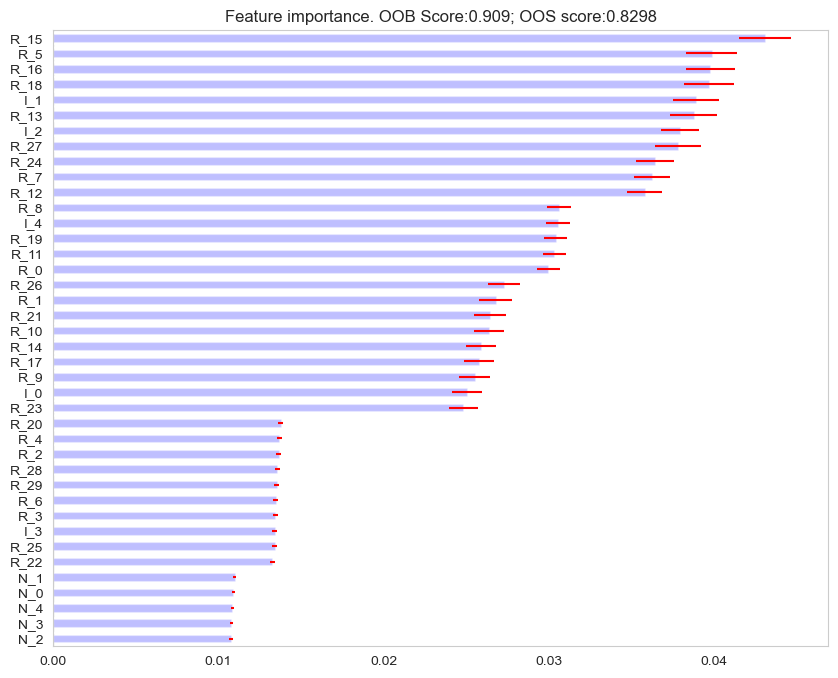

In [12]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

$p$-value의 네 가지 결함 중 MDI 방법은 다음과 같은 세 가지를 다루고 있다. (1) MDI의 계산적 특성은 틀릴 수 있는 강력한 분포 가정의 필요성을 회피한다. 특정 트리 구조나 대수적 사양을 부과하거나 잔차의 확률적 또는 분포적 특성에 의존하지 않는다. (2) Beta가 단일 햄플에 대해 추정되는 반면, Ensemblt MDI는 Tree의 Bootstrap에서 도출된다. 따라서 MDI 추정치의 분산은 일반적으로 앙상블 방법이나 특히 Random Forest에서 트리의 수를 증가시킴으로써 줄일 수 있다. 이것은 Overfitting으로 인한 false positive의 확률을 감소시킨다. 또한 $p$-value 값과 달리 MDI의 추정에 따라 비특이일 수 있는 행렬의 역행렬을 요구하지 않는다. (3) 트리에 기초한 분류기의 목적은 주어진 대수 방정식의 계수를 추정하는 것이 아니므로 특정 귀무가설의 확률을 추정하는 것과는 무관하다. 즉 MDI는 특정 parameter 사양과 무관하게 일반적으로 중요한 특성을 찾아 세 번째 결함을 교정한다. 

MDI의 앙상블 추정치는 트리의 수가 충분할 경우 분산이 적어 $p$-hacking의 우려를 줄일 수 있다. 그러나 여전히 그 절차 자체는 교차 검증을 수반하지 않는다. 따라서 MDI가 완전하게 해결하지 못하는 $p$-value의 한 가지 결함은 MDI도 샘플 내에서 계산된다는 것이다. 이 마지막 결함에 맞서려면 Mean Decrease Accuracy의 개념을 도입해야 한다.

#### 2. Mean Decrease Accuracy

p-value와 MDI 모두 설명 목적으로 샘플 내에서 유의적으로 보이는 변수가 예측의 목적과 무관할 수 있다는 점이다. 이 문제를 해결하고자, MDA 특성 중요도가 제안되었다

MDA는 다음과 같이 동작한다. 
1. 모델을 적합화시키고 교차 검증된 성과를 계산한다
2. 동일한 적합화 모델읠 교차 검증된 성과를 하는데, 단 하나의 차이점은 feature 중 하나와 관련된 관찰값들을 셔플링한다는 것이다. 그것은 특성당 하나의 수정된 교차검증 성능을 제공한다
3. 셔플링 전후의 교차 검증된 성능을 비교함으로써, 특정 feature와 연관된 MDA score를 도출한다. **특성이 중요하다면 특성이 독립인 경우, 셔플링으로 인해 성과의 현저한 저하 현성이 있어야 한다**

MDA의 중요한 속성은 앙상블 MDI와 마찬가지로 단일 추정치의 결과가 아니라 다중 추정치의 평균이라는 것이다.

In [14]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [15]:
mda = mean_decrease_accuracy(
    fit, # base classification model
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

5it [02:16, 27.21s/it]
/Users/junghunlee/Desktop/Pycharm/2025-01MLFinanceLab/FinancialMachineLearning/feature_importance/importance.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  importance.replace([-np.inf, np.nan], 0, inplace=True)


In [16]:
mda.head()

,mean,std
I_0,0.007923,0.004064
I_1,0.000121,0.025845
I_2,0.025089,0.054955
I_3,0.009845,0.008871
I_4,0.022778,0.026152


아래의 그림은 위 MDI의 그림에서 논의한 것과 동일한 무작위 분류 문제에 MDA를 적용한 결과를 나타낸다. MDI 사례에서 했던 것과 비슷한 결론을 도출하고 있다. 첫째, MDA는 잡음 특성과 나머지 요소를 분리하는 데 전반적으로 좋은 성과를 보이고 있다. 잡음 특성은 순위가 가장 낮다. 둘째, 잡음 특성은 MDA 값이 본질적으로 0이므로 크기로는 중요하지 않은 것으로 간주된다. 셋째, 대체 효과(substitution effect, Multicolinearity)가 MDA 중요도의 분산을 증가시키지만, 비잡음적 특성의 중요도에 의문을 제기할 만큼 높은 것은 없다.

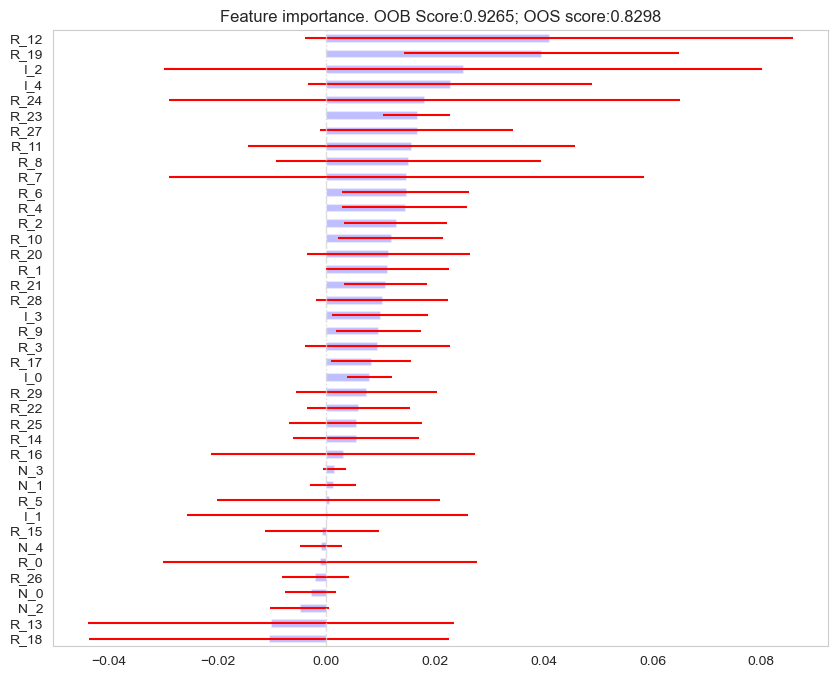

In [17]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

MDA는 이름에도 불구하고 교차 검증된 성능을 평가하고자 정확도에 반드시 의존하지는 않는다. MDA는 다른 성과 점수로 계산할 수 있다. 사실, 금융이란 특수한 경우에 있어 정확도는 특별히 좋은 선택이 아니다. 그 이유는 정확도가 정확한 예측의 비율로 분류기의 점수를 메기기 때문이다. 따라서, 확률을 고려하지 않는다는 단점이 있다.

예를 들어, 분류기는 낮은 신뢰도로 좋은 예측을 하고 높은 신뢰도로 나쁜 예측을 했음에도 높은 정확도를 달성할 수 있다. 다음 절에서는 이 문제를 해결하는 scoring함수를 소개한다.

### Probability-Weighted Accuracy

금융 응용에서 정확도에 대한 좋은 대안은 log loss이다. log loss는 True Label의 평균 로그 우도 측면에서 분류기를 점수화한다. 그러나, 한 가지 단점은 Log Loss 점수를 해석하고 비교하기가 쉽지 않다는 점이다. 가능한 해결책은 True Label의 Negative Average Likelihood를 계산하는 것이다.

$$\text{NegAL} = -N^{-1}\sum_{n=0}^{N-1} \sum_{k=0}^{K-1} y_{n,k}p_{n,k}$$

여기서 $p_{n,k}$는 label $k$의 예측 $n$과 관련된 확률이며, $p_{n,k}$는 지표 함수, $y_{n,k} \in \{0,1\}$이며, 여기서 $n$이 label $k$에 할당됐을 때는 $y_{n,k} = 1$이고, 할당되지 않았을 때는 $y_{n,k} = 0$이다. 이는 log loss와 매우 유사하나, 로그 우도가 아니라 우도의 평균을 한다는 점에서 다르며, $\text{NegAL}$의 범위는 여전히 0과 1 사이이다.

또는 확률 가중 정확도(Probability Weighted Accuracy)를 다음과 같이 정의할 수 있다.

$$\text{PWA} = \frac{\sum_{n=0}^{N-1} y_n \left( p_n K^{-1}\right)}{\sum_{n=0}^{N-1}\left( p_n K^{-1}\right)}$$

여기서 $p_n = \max_k \{p_{n,k}\}$이고 $y_n$은 지표 함수이고, $y_n \in \{0,1\}$이고, 예측이 정확할 때 $y_n = 1$이고 아니면 $y_n = 0$이다. 이는 분류기가 모든 예측에 절대적인 확신을 가질 때의 표준 정확도와 동일하다. PWA는 높은 신뢰도를 갖고 한 잘못된 예측에 대해 정확도보다 더욱 심파게 패널티를 가하는데, log loss보다는 덜 심하게 패널티를 가한다.